In [2]:
import math
import numpy as np
import matplotlib.pyplot as plt

import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
class TimeSeriesDataset(Dataset):
  def __init__(self, data, depth, step):
    super(TimeSeriesDataset, self).__init__()
    
    self.data = np.genfromtxt(data, delimiter="")

    dmax = np.amax(self.data, axis=0)
    dmin = np.amin(self.data, axis=0)

    self.data = (self.data - dmin) / (dmax - dmin)

    self.dmax = dmax[-1]
    self.dmin = dmin[-1]

    self.x = []
    self.y = []

    for i in range(depth, len(self.data)-step+1):
      self.x.append(self.data[i-depth:i,:])
      self.y.append(self.data[i:i+step,-1])
    
    self.x = torch.tensor(np.array(self.x)).float().to(device)
    self.y = torch.tensor(np.array(self.y)).float().to(device)

  def __getitem__(self, idx):
    return self.x[idx], self.y[idx]

  def __len__(self):
    return len(self.x)

In [5]:
train_1 = TimeSeriesDataset("./train1.txt", depth=13, step=1)
train_2 = TimeSeriesDataset("./train2.txt", depth=13, step=1)

dataloader_1 = DataLoader(train_1, batch_size=32)
dataloader_2 = DataLoader(train_2, batch_size=32)

In [6]:
class CustomLSTM(nn.Module):
  def __init__(self, input_size, hidden_size):
    super(CustomLSTM, self).__init__()

    # input size, hidden size
    self.input_size = input_size
    self.hidden_size = hidden_size

    # gate size
    gate_size = 4 * hidden_size

    # weight
    self.w_ih = nn.Parameter(torch.Tensor(self.input_size, gate_size))
    self.w_hh = nn.Parameter(torch.Tensor(self.hidden_size, gate_size))
    
    # bias
    self.b = nn.Parameter(torch.Tensor(gate_size))

    # weight initialization
    stdv = 1.0 / math.sqrt(self.hidden_size)
    for w in self.parameters():
      w.data.uniform_(-stdv, stdv)

  def forward(self, x):
    # B : batch size, L : sequence length(depth)
    B, L = x.size(0), x.size(1)

    output = []

    # initial values
    ht = torch.zeros(B, self.hidden_size).to(device)
    ct = torch.zeros(B, self.hidden_size).to(device)

    for t in range(L):
      xt = x[:,t,:]
      gates = xt @ self.w_ih + ht @ self.w_hh + self.b

      it = torch.sigmoid(gates[:,:self.hidden_size])
      ft = torch.sigmoid(gates[:,self.hidden_size:2*self.hidden_size])
      gt = torch.tanh(gates[:,2*self.hidden_size:3*self.hidden_size])
      ot = torch.sigmoid(gates[:,3*self.hidden_size:])

      ct = ft * ct + it + gt
      ht = ot * torch.tanh(ct)

      output.append(ht.unsqueeze(1))

    output = torch.cat(output, dim=1)
    return output, (ht, ct)

In [7]:
class SingleStepPrediction(nn.Module):
  def __init__(self, input_size, hidden_size):
    super(SingleStepPrediction, self).__init__()

    self.lstm = CustomLSTM(input_size, hidden_size)
    self.fc = nn.Linear(hidden_size, 1)

  def forward(self, x):
    out, (ht, ct) = self.lstm(x) # B x h
    output = self.fc(ht) # B x 1
    return output

In [8]:
model = SingleStepPrediction(input_size=9, hidden_size=8).to(device)

criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [9]:
for epoch in range(100):
  for i, data in enumerate(dataloader_1):
    inputs, labels = data
    optimizer.zero_grad()
    outputs = model(inputs)
    loss = criterion(outputs, labels)
    loss.backward()
    optimizer.step()

  for i, data in enumerate(dataloader_2):
    inputs, labels = data
    optimizer.zero_grad()
    outputs = model(inputs)
    loss = criterion(outputs, labels)
    loss.backward()
    optimizer.step()

In [10]:
test = TimeSeriesDataset("./test.txt", depth=13, step=1)

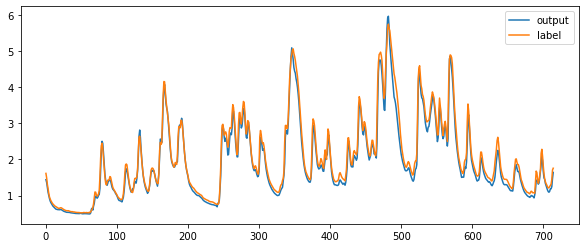

RMSE : 0.18251356482505798


In [11]:
label = []
output = []

for i in range(len(test)):
  x, y = test.__getitem__(i)
  x = x.unsqueeze(0)
  out = model(x)
  
  y = y * (test.dmax - test.dmin) + test.dmin
  y = y.cpu().detach().numpy()
  label.append(y)

  out = out.squeeze(1)
  out = out * (test.dmax - test.dmin) + test.dmin
  out = out.cpu().detach().numpy()
  output.append(out)

fig = plt.figure(figsize=(10, 4))
plt.plot(output, label="output")
plt.plot(label, label="label")
plt.legend()
plt.show()

label = np.array(label)
output = np.array(output)

print(f"RMSE : {np.sqrt(np.mean((label - output)**2))}")

In [19]:
def performance_test():
  RMSE = []

  for t in range(100):
    model = SingleStepPrediction(input_size=9, hidden_size=8).to(device)

    criterion = torch.nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

    for epoch in range(10):
      for i, data in enumerate(dataloader_1):
        inputs, labels = data
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

      for i, data in enumerate(dataloader_2):
        inputs, labels = data
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
    
    label = []
    output = []

    for i in range(len(test)):
      x, y = test.__getitem__(i)
      x = x.unsqueeze(0)
      out = model(x)
  
      y = y * (test.dmax - test.dmin) + test.dmin
      y = y.cpu().detach().numpy()
      label.append(y)

      out = out.squeeze(1)
      out = out * (test.dmax - test.dmin) + test.dmin
      out = out.cpu().detach().numpy()
      output.append(out)
    
    label = np.array(label)
    output = np.array(output)
    
    RMSE.append(np.sqrt(np.mean((label - output)**2)))
  
  rmse = sum(RMSE) / 100
  return rmse

In [20]:
print(f"RMSE : {performance_test()}")

RMSE : 0.3192582373321056
